# Type 1 → Type 4 Single Iteration Analysis (COMPLETE)

## PADBen: Paraphrase Attack Detection Benchmark
### CS6120 Natural Language Processing - Northeastern University

**Authors:** Zaid Shaikh, Rahul Leonard Arun Kumar, Aryan Singh  
**Advisor:** Prof. Shanu Sushmita 
**Date:** December 2025

---

## Overview

This notebook provides a **comprehensive semantic drift analysis** comparing:
- **Type 1:** Human Original Text
- **Type 4:** LLM-Paraphrased Original Text (prompt-based)

### Methodology (from SemanticDrift_MileStone2)
We implement the full semantic drift scoring framework:

1. **SBERT Embeddings:** Using `all-mpnet-base-v2` for high-quality sentence embeddings
2. **Euclidean Distance:** Between embedding vectors
3. **METEOR Score:** Metric for Evaluation of Translation with Explicit Ordering
4. **ROUGE-L:** Longest Common Subsequence-based evaluation
5. **BERTScore:** Contextual embedding similarity
6. **MinMax Normalization:** Scaling all metrics to [0,1] range
7. **Composite SDS:** `0.6 * SBERT_norm + 0.2 * METEOR_norm + 0.2 * ROUGE_norm`

### ParaScore Integration
Validating against ParaScore framework (EMNLP 2022):
- **Threshold:** γ = 0.35 (quality collapse boundary)
- **Distance Effect:** Metrics degrade as text diverges
- **Dual-Criteria:** Combining semantic + lexical analysis

---

## Cell 1: Environment Setup and Dependencies

In [7]:
# Install required packages (run once)
# Uncomment if running in a new environment

# !pip install sentence-transformers nltk rouge-score bert-score scipy scikit-learn seaborn tqdm python-Levenshtein

In [1]:
# Core imports
import json
import re
import warnings
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# NLP Libraries
import nltk
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

# Sentence Transformers (SBERT)
from sentence_transformers import SentenceTransformer

# BERTScore
from bert_score import score as bert_score_compute

# Sklearn for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# scipy for distance metrics
from scipy.spatial.distance import euclidean

# Levenshtein for edit distance
from Levenshtein import distance as lev_distance

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All dependencies loaded successfully!")

/Users/zaidshaikh/GitHub/padben_eda_notebook/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All dependencies loaded successfully!


In [2]:
# Configuration
# ============================================================================

# Paths - Adjust these based on your environment
DATA_PATH = Path('../../data.json')  # Relative to SDS_ParaScore/Type1_Type4_SingleIteration/
OUTPUT_DIR = Path('.')  # Current directory

# If running from different location, use absolute path:
# DATA_PATH = Path('/Users/zaidshaikh/GitHub/padben_eda_notebook/data.json')

# Column names in data.json
COL_TYPE1 = 'human_original_text(type1)'
COL_TYPE4 = 'llm_paraphrased_original_text(type4)-prompt-based'

# ParaScore thresholds
PARASCORE_THRESHOLD = 0.35  # Quality collapse boundary
LOW_MED_THRESHOLD = 0.35    # Low-Medium drift boundary
MED_HIGH_THRESHOLD = 0.45   # Medium-High drift boundary

# Composite SDS weights (from SemanticDrift_MileStone2)
WEIGHT_SBERT = 0.6
WEIGHT_METEOR = 0.2
WEIGHT_ROUGE = 0.2

# Model configuration
SBERT_MODEL = 'all-mpnet-base-v2'  # High-quality sentence embeddings

# Visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("✅ Configuration loaded!")
print(f"   Data path: {DATA_PATH}")
print(f"   Output dir: {OUTPUT_DIR}")
print(f"   SBERT model: {SBERT_MODEL}")
print(f"   SDS weights: SBERT={WEIGHT_SBERT}, METEOR={WEIGHT_METEOR}, ROUGE={WEIGHT_ROUGE}")

✅ Configuration loaded!
   Data path: ../../data.json
   Output dir: .
   SBERT model: all-mpnet-base-v2
   SDS weights: SBERT=0.6, METEOR=0.2, ROUGE=0.2


## Cell 2: Data Loading and Initial Exploration

In [3]:
# Load the dataset
print("="*70)
print("📂 LOADING DATA")
print("="*70)

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

print(f"\n✅ Loaded {len(df)} samples")
print(f"\n📊 Column Overview:")
print(df.columns.tolist())

print(f"\n📊 Data Types:")
print(df.dtypes)

print(f"\n📊 Null Counts:")
print(df.isna().sum())

📂 LOADING DATA

✅ Loaded 5000 samples

📊 Column Overview:
['idx', 'dataset_source', 'human_original_text(type1)', 'llm_generated_text(type2)', 'human_paraphrased_text(type3)', 'llm_paraphrased_original_text(type4)-prompt-based', 'llm_paraphrased_generated_text(type5)-1st', 'llm_paraphrased_generated_text(type5)-3rd']

📊 Data Types:
idx                                                   int64
dataset_source                                       object
human_original_text(type1)                           object
llm_generated_text(type2)                            object
human_paraphrased_text(type3)                        object
llm_paraphrased_original_text(type4)-prompt-based    object
llm_paraphrased_generated_text(type5)-1st            object
llm_paraphrased_generated_text(type5)-3rd            object
dtype: object

📊 Null Counts:
idx                                                  0
dataset_source                                       0
human_original_text(type1)                    

In [4]:
# Create standardized column names for easier access
df['Type_1'] = df[COL_TYPE1]
df['Type_4'] = df[COL_TYPE4]

# Display sample data
print("\n📝 Sample Text Pairs (Type 1 → Type 4):")
print("="*70)
for i in range(3):
    print(f"\n--- Sample {i+1} ---")
    print(f"Type 1 (Human): {df['Type_1'].iloc[i][:100]}...")
    print(f"Type 4 (LLM):   {df['Type_4'].iloc[i][:100]}...")


📝 Sample Text Pairs (Type 1 → Type 4):

--- Sample 1 ---
Type 1 (Human): Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidenc...
Type 4 (LLM):   Amrozi charged his brother, "the witness," with willfully misrepresenting his account....

--- Sample 2 ---
Type 1 (Human): They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he ad...
Type 4 (LLM):   He noted they had advertised the cargo for sale online in a listing posted June 10....

--- Sample 3 ---
Type 1 (Human): The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Excha...
Type 4 (LLM):   Shares gained $2.11 (about 11%), concluding Friday's trading at $21.51 on the NYSE....


In [5]:
# Basic text statistics
def simple_tokenize(text):
    """Simple tokenization for length analysis"""
    return re.findall(r'\w+', str(text).lower())

df['len_type1_tokens'] = df['Type_1'].apply(lambda x: len(simple_tokenize(x)))
df['len_type4_tokens'] = df['Type_4'].apply(lambda x: len(simple_tokenize(x)))
df['len_delta_tokens'] = df['len_type4_tokens'] - df['len_type1_tokens']

print("\n📊 Token Length Statistics:")
print(df[['len_type1_tokens', 'len_type4_tokens', 'len_delta_tokens']].describe().round(2))


📊 Token Length Statistics:
       len_type1_tokens  len_type4_tokens  len_delta_tokens
count           5000.00           5000.00           5000.00
mean              26.03             23.30             -2.74
std               41.96             40.34              4.68
min                4.00              4.00           -129.00
25%               16.00             14.00             -4.00
50%               20.00             17.00             -2.00
75%               24.00             21.00             -1.00
max              444.00            453.00             38.00


## Cell 3: SBERT Embedding Computation

Using `all-mpnet-base-v2` model for high-quality sentence embeddings.
This is the **same model** used in SemanticDrift_MileStone2.

In [6]:
# Initialize SBERT model
print("="*70)
print(f"🤖 LOADING SBERT MODEL: {SBERT_MODEL}")
print("="*70)

sbert_model = SentenceTransformer(SBERT_MODEL)
print("✅ Model loaded successfully!")
print(f"   Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

🤖 LOADING SBERT MODEL: all-mpnet-base-v2
✅ Model loaded successfully!
   Embedding dimension: 768
✅ Model loaded successfully!
   Embedding dimension: 768


In [7]:
# Compute SBERT embeddings
print("\n🔄 Computing SBERT embeddings...")

# Type 1 embeddings
print("   Encoding Type 1 (Human Original)...")
type1_embeddings = sbert_model.encode(
    df['Type_1'].tolist(), 
    batch_size=32, 
    show_progress_bar=True
)

# Type 4 embeddings
print("   Encoding Type 4 (LLM Paraphrased)...")
type4_embeddings = sbert_model.encode(
    df['Type_4'].tolist(), 
    batch_size=32, 
    show_progress_bar=True
)

print("\n✅ Embeddings computed!")
print(f"   Type 1 shape: {type1_embeddings.shape}")
print(f"   Type 4 shape: {type4_embeddings.shape}")


🔄 Computing SBERT embeddings...
   Encoding Type 1 (Human Original)...


Batches: 100%|██████████| 157/157 [00:45<00:00,  3.48it/s]


   Encoding Type 4 (LLM Paraphrased)...


Batches: 100%|██████████| 157/157 [00:43<00:00,  3.64it/s]


✅ Embeddings computed!
   Type 1 shape: (5000, 768)
   Type 4 shape: (5000, 768)


In [8]:
# Calculate Euclidean distance between embeddings
print("\n🔄 Computing Euclidean distances...")

sbert_euclidean = []
for i in tqdm(range(len(df)), desc="Euclidean distances"):
    dist = euclidean(type1_embeddings[i], type4_embeddings[i])
    sbert_euclidean.append(dist)

df['sbert_euclid'] = sbert_euclidean

# Also compute cosine similarity for reference
sbert_cosine = []
for i in range(len(df)):
    cos_sim = cosine_similarity(
        np.array([type1_embeddings[i]]), 
        np.array([type4_embeddings[i]])
    )[0][0]
    sbert_cosine.append(cos_sim)

df['sbert_cosine'] = sbert_cosine

print("\n✅ SBERT metrics computed!")
print(f"   Euclidean mean: {df['sbert_euclid'].mean():.4f}")
print(f"   Cosine sim mean: {df['sbert_cosine'].mean():.4f}")


🔄 Computing Euclidean distances...


Euclidean distances: 100%|██████████| 5000/5000 [00:00<00:00, 147728.37it/s]




✅ SBERT metrics computed!
   Euclidean mean: 0.4421
   Cosine sim mean: 0.8912


## Cell 4: METEOR Score Computation

METEOR (Metric for Evaluation of Translation with Explicit Ordering) evaluates 
paraphrase quality based on exact, stem, synonym, and paraphrase matches.

In [9]:
# Calculate METEOR scores
print("="*70)
print("📊 COMPUTING METEOR SCORES")
print("="*70)

meteor_scores = []
for i in tqdm(range(len(df)), desc="METEOR scores"):
    ref_tokens = simple_tokenize(df['Type_1'].iloc[i])
    hyp_tokens = simple_tokenize(df['Type_4'].iloc[i])
    
    # METEOR expects reference as list of token lists
    score = meteor_score([ref_tokens], hyp_tokens)
    meteor_scores.append(score)

df['meteor'] = meteor_scores

# Create inverted version (higher = more drift)
df['meteor_inv'] = 1 - df['meteor']

print("\n✅ METEOR scores computed!")
print(f"   Mean METEOR: {df['meteor'].mean():.4f}")
print(f"   Mean METEOR (inverted): {df['meteor_inv'].mean():.4f}")

📊 COMPUTING METEOR SCORES


METEOR scores: 100%|██████████| 5000/5000 [00:04<00:00, 1101.12it/s]


✅ METEOR scores computed!
   Mean METEOR: 0.5437
   Mean METEOR (inverted): 0.4563


## Cell 5: ROUGE-L Score Computation

ROUGE-L measures the longest common subsequence between generated and reference text.

In [10]:
# Calculate ROUGE-L scores
print("="*70)
print("📊 COMPUTING ROUGE-L SCORES")
print("="*70)

# Initialize ROUGE scorer with stemmer for robust matching
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

rouge_l_scores = []
for i in tqdm(range(len(df)), desc="ROUGE-L scores"):
    scores = rouge_scorer_obj.score(
        df['Type_1'].iloc[i], 
        df['Type_4'].iloc[i]
    )
    # Use F-measure for balanced precision/recall
    rouge_l_scores.append(scores['rougeL'].fmeasure)

df['rouge_l'] = rouge_l_scores

# Create inverted version (higher = more drift)
df['rouge_l_inv'] = 1 - df['rouge_l']

print("\n✅ ROUGE-L scores computed!")
print(f"   Mean ROUGE-L: {df['rouge_l'].mean():.4f}")
print(f"   Mean ROUGE-L (inverted): {df['rouge_l_inv'].mean():.4f}")

📊 COMPUTING ROUGE-L SCORES


ROUGE-L scores: 100%|██████████| 5000/5000 [00:03<00:00, 1528.70it/s]


✅ ROUGE-L scores computed!
   Mean ROUGE-L: 0.5276
   Mean ROUGE-L (inverted): 0.4724


## Cell 6: BERTScore Computation

BERTScore computes similarity using contextual embeddings from BERT.

In [11]:
# Calculate BERTScore
print("="*70)
print("📊 COMPUTING BERTSCORE")
print("="*70)
print("(This may take a few minutes...)")

# BERTScore returns precision, recall, F1
P, R, F1 = bert_score_compute(
    df['Type_4'].tolist(),  # Candidate/hypothesis
    df['Type_1'].tolist(),  # Reference
    lang='en',
    verbose=True
)

df['bertscore_p'] = P.numpy()
df['bertscore_r'] = R.numpy()
df['bertscore_f1'] = F1.numpy()

# Create inverted version for drift calculation
df['bertscore_inv'] = 1 - df['bertscore_f1']

print("\n✅ BERTScore computed!")
print(f"   Mean Precision: {df['bertscore_p'].mean():.4f}")
print(f"   Mean Recall: {df['bertscore_r'].mean():.4f}")
print(f"   Mean F1: {df['bertscore_f1'].mean():.4f}")

📊 COMPUTING BERTSCORE
(This may take a few minutes...)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 157/157 [06:08<00:00,  2.35s/it]


computing greedy matching.


100%|██████████| 79/79 [00:01<00:00, 43.80it/s]



done in 370.90 seconds, 13.48 sentences/sec

✅ BERTScore computed!
   Mean Precision: 0.9461
   Mean Recall: 0.9255
   Mean F1: 0.9356


## Cell 7: Additional Lexical Metrics

Computing Jaccard similarity and Edit Distance for lexical analysis.

In [12]:
# Calculate Jaccard similarity
print("="*70)
print("📊 COMPUTING LEXICAL METRICS")
print("="*70)

def jaccard_similarity(text1, text2):
    """Calculate Jaccard similarity between two texts"""
    tokens1 = set(simple_tokenize(text1))
    tokens2 = set(simple_tokenize(text2))
    if not tokens1 and not tokens2:
        return 1.0
    intersection = len(tokens1 & tokens2)
    union = len(tokens1 | tokens2)
    return intersection / union if union > 0 else 0.0

jaccard_scores = []
for i in tqdm(range(len(df)), desc="Jaccard similarity"):
    score = jaccard_similarity(df['Type_1'].iloc[i], df['Type_4'].iloc[i])
    jaccard_scores.append(score)

df['jaccard'] = jaccard_scores
df['jaccard_div'] = 1 - df['jaccard']  # Divergence version

print(f"   Mean Jaccard similarity: {df['jaccard'].mean():.4f}")

📊 COMPUTING LEXICAL METRICS


Jaccard similarity: 100%|██████████| 5000/5000 [00:00<00:00, 33339.09it/s]

   Mean Jaccard similarity: 0.4480


In [13]:
# Calculate normalized Edit Distance
def normalized_edit_distance(text1, text2):
    """Calculate normalized Levenshtein distance"""
    if not text1 and not text2:
        return 0.0
    max_len = max(len(str(text1)), len(str(text2)))
    if max_len == 0:
        return 0.0
    return lev_distance(str(text1), str(text2)) / max_len

edit_distances = []
for i in tqdm(range(len(df)), desc="Edit distance"):
    dist = normalized_edit_distance(df['Type_1'].iloc[i], df['Type_4'].iloc[i])
    edit_distances.append(dist)

df['edit_norm'] = edit_distances

print(f"   Mean normalized edit distance: {df['edit_norm'].mean():.4f}")

Edit distance: 100%|██████████| 5000/5000 [00:00<00:00, 54816.75it/s]

   Mean normalized edit distance: 0.5102


## Cell 8: MinMax Normalization

Normalizing all drift metrics to [0,1] range for comparable weighting.

In [14]:
# Apply MinMax normalization
print("="*70)
print("📊 APPLYING MINMAX NORMALIZATION")
print("="*70)

scaler = MinMaxScaler()

# Normalize the three main drift metrics
# Note: sbert_euclid, meteor_inv, rouge_l_inv are all "higher = more drift"
metrics_to_normalize = ['sbert_euclid', 'meteor_inv', 'rouge_l_inv']

df[['sbert_norm', 'meteor_norm', 'rougel_norm']] = scaler.fit_transform(
    df[metrics_to_normalize]
)

print("\n📊 Normalized Metrics Statistics:")
print(df[['sbert_norm', 'meteor_norm', 'rougel_norm']].describe().round(4))

📊 APPLYING MINMAX NORMALIZATION

📊 Normalized Metrics Statistics:
       sbert_norm  meteor_norm  rougel_norm
count   5000.0000    5000.0000    5000.0000
mean       0.3849       0.4561       0.4521
std        0.1522       0.1632       0.1531
min        0.0000       0.0000       0.0000
25%        0.2764       0.3405       0.3456
50%        0.3723       0.4492       0.4490
75%        0.4769       0.5663       0.5557
max        1.0000       1.0000       1.0000


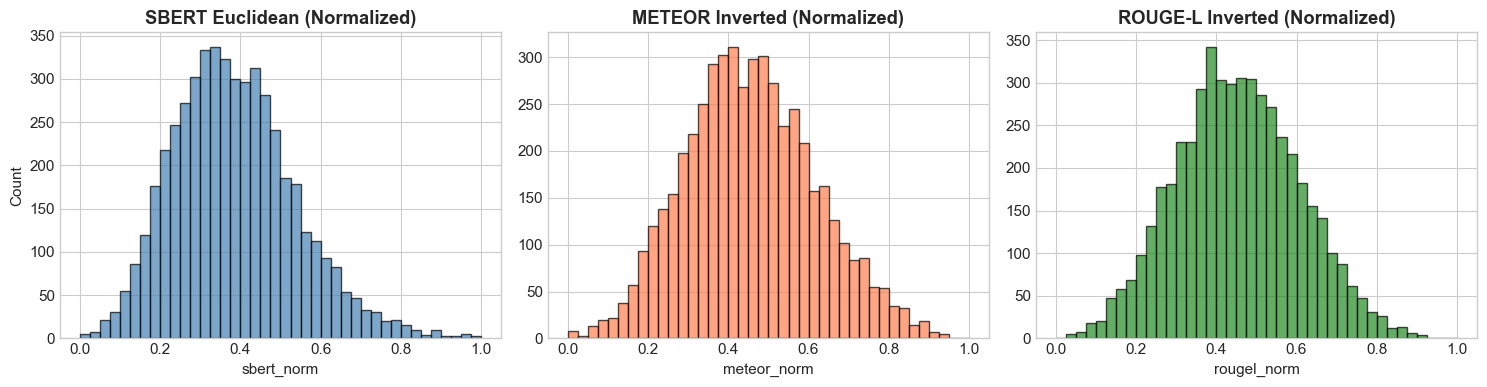

In [22]:
# Visualize normalized distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['sbert_norm'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('SBERT Euclidean (Normalized)', fontweight='bold')
axes[0].set_xlabel('sbert_norm')
axes[0].set_ylabel('Count')

axes[1].hist(df['meteor_norm'], bins=40, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('METEOR Inverted (Normalized)', fontweight='bold')
axes[1].set_xlabel('meteor_norm')

axes[2].hist(df['rougel_norm'], bins=40, edgecolor='black', alpha=0.7, color='forestgreen')
axes[2].set_title('ROUGE-L Inverted (Normalized)', fontweight='bold')
axes[2].set_xlabel('rougel_norm')

plt.tight_layout()
plt.show()

## Cell 9: Composite Semantic Drift Score (SDS)

Calculating the weighted SDS as defined in SemanticDrift_MileStone2:

$$SDS = 0.6 \times SBERT_{norm} + 0.2 \times METEOR_{norm} + 0.2 \times ROUGE_{norm}$$

In [15]:
# Calculate Composite Semantic Drift Score
print("="*70)
print("📊 CALCULATING COMPOSITE SEMANTIC DRIFT SCORE (SDS)")
print("="*70)

df['SDS'] = (
    WEIGHT_SBERT * df['sbert_norm'] +
    WEIGHT_METEOR * df['meteor_norm'] +
    WEIGHT_ROUGE * df['rougel_norm']
)

print("\n✅ Composite SDS calculated!")
print(f"   Weights: SBERT={WEIGHT_SBERT}, METEOR={WEIGHT_METEOR}, ROUGE={WEIGHT_ROUGE}")
print("\n📊 SDS Statistics:")
print(df['SDS'].describe().round(4))

📊 CALCULATING COMPOSITE SEMANTIC DRIFT SCORE (SDS)

✅ Composite SDS calculated!
   Weights: SBERT=0.6, METEOR=0.2, ROUGE=0.2

📊 SDS Statistics:
count    5000.0000
mean        0.4126
std         0.1322
min         0.0091
25%         0.3195
50%         0.4049
75%         0.4955
max         0.9150
Name: SDS, dtype: float64


In [16]:
# Create drift categories
df['drift_category'] = pd.cut(
    df['SDS'],
    bins=[0, LOW_MED_THRESHOLD, MED_HIGH_THRESHOLD, 1.0],
    labels=['Low Drift', 'Medium Drift', 'High Drift']
)

print("\n📊 Drift Category Distribution:")
print(df['drift_category'].value_counts())
print("\n📊 Drift Category Percentages:")
print(df['drift_category'].value_counts(normalize=True).round(4) * 100)


📊 Drift Category Distribution:
drift_category
High Drift      1868
Low Drift       1657
Medium Drift    1475
Name: count, dtype: int64

📊 Drift Category Percentages:
drift_category
High Drift      37.36
Low Drift       33.14
Medium Drift    29.50
Name: proportion, dtype: float64


## Cell 10: Correlation Analysis

Analyzing correlations between all drift metrics.

📊 CORRELATION ANALYSIS


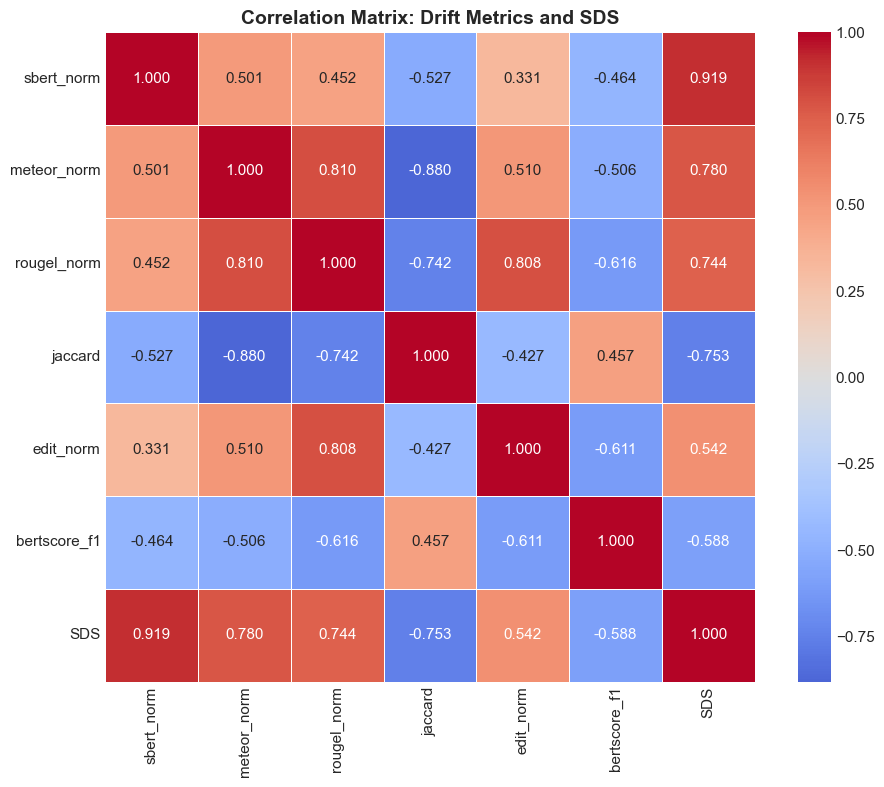

In [26]:
# Correlation heatmap
print("="*70)
print("📊 CORRELATION ANALYSIS")
print("="*70)

corr_cols = [
    'sbert_norm', 'meteor_norm', 'rougel_norm', 
    'jaccard', 'edit_norm', 'bertscore_f1', 'SDS'
]

corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    fmt='.3f',
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix: Drift Metrics and SDS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Cell 10a: Individual Metric Analysis (CRITICAL)

**Rahul's Insight:** Instead of relying solely on composite SDS, we analyze each metric individually to understand how they react to semantic drift.

This section answers:
1. **Which metric is most sensitive to paraphrasing?**
2. **Do semantic (SBERT, BERTScore) and lexical (METEOR, ROUGE) metrics tell different stories?**
3. **How does each metric individually characterize the Type 1 → Type 4 transformation?**

In [17]:
# INDIVIDUAL METRIC ANALYSIS - Raw Metrics (not normalized)
print("="*70)
print("📊 INDIVIDUAL METRIC ANALYSIS - RAW VALUES")
print("="*70)

# Define metrics for individual analysis
individual_metrics = {
    'SBERT Euclidean': 'sbert_euclid',
    'SBERT Cosine Sim': 'sbert_cosine', 
    'METEOR Score': 'meteor',
    'ROUGE-L Score': 'rouge_l',
    'BERTScore F1': 'bertscore_f1',
    'Jaccard Similarity': 'jaccard',
    'Edit Distance (Norm)': 'edit_norm'
}

# Create comprehensive statistics table
stats_data = []
for name, col in individual_metrics.items():
    if col in df.columns:
        stats_data.append({
            'Metric': name,
            'Mean': df[col].mean(),
            'Std': df[col].std(),
            'Min': df[col].min(),
            'Max': df[col].max(),
            'Median': df[col].median(),
            'Q25': df[col].quantile(0.25),
            'Q75': df[col].quantile(0.75)
        })

stats_df = pd.DataFrame(stats_data)
print("\n📊 Individual Metric Statistics (Raw Values):")
print(stats_df.to_string(index=False))

# Identify metric sensitivity
print("\n" + "="*70)
print("📊 METRIC SENSITIVITY ANALYSIS")
print("="*70)

# For similarity metrics (higher = more similar), invert to get "drift"
# For distance metrics (higher = more different), keep as is
print("\n📈 Metric Interpretation for Drift Detection:")
print("-" * 50)
print("• SBERT Euclidean: Higher = MORE drift (distance metric)")
print("• SBERT Cosine: Lower = MORE drift (similarity metric)")  
print("• METEOR: Lower = MORE drift (similarity metric)")
print("• ROUGE-L: Lower = MORE drift (similarity metric)")
print("• BERTScore: Lower = MORE drift (similarity metric)")
print("• Jaccard: Lower = MORE drift (similarity metric)")
print("• Edit Distance: Higher = MORE drift (distance metric)")

📊 INDIVIDUAL METRIC ANALYSIS - RAW VALUES

📊 Individual Metric Statistics (Raw Values):
              Metric     Mean      Std      Min      Max   Median      Q25      Q75
     SBERT Euclidean 0.442060 0.149239 0.064699 1.045236 0.429785 0.335684 0.532268
    SBERT Cosine Sim 0.891158 0.073642 0.453741 0.997907 0.907642 0.858346 0.943658
        METEOR Score 0.543727 0.163184 0.000000 0.999711 0.550617 0.433547 0.659338
       ROUGE-L Score 0.527603 0.147450 0.000000 0.962963 0.530612 0.427812 0.630117
        BERTScore F1 0.935649 0.018743 0.847645 0.991097 0.936780 0.924129 0.948533
  Jaccard Similarity 0.448008 0.150156 0.000000 1.000000 0.440000 0.344828 0.543279
Edit Distance (Norm) 0.510210 0.147783 0.086957 0.861702 0.505848 0.405941 0.612979

📊 METRIC SENSITIVITY ANALYSIS

📈 Metric Interpretation for Drift Detection:
--------------------------------------------------
• SBERT Euclidean: Higher = MORE drift (distance metric)
• SBERT Cosine: Lower = MORE drift (similarity metric)


🎨 GENERATING FIGURE: INDIVIDUAL METRIC DISTRIBUTIONS

✅ Figure saved: individual_metric_distributions.png

✅ Figure saved: individual_metric_distributions.png


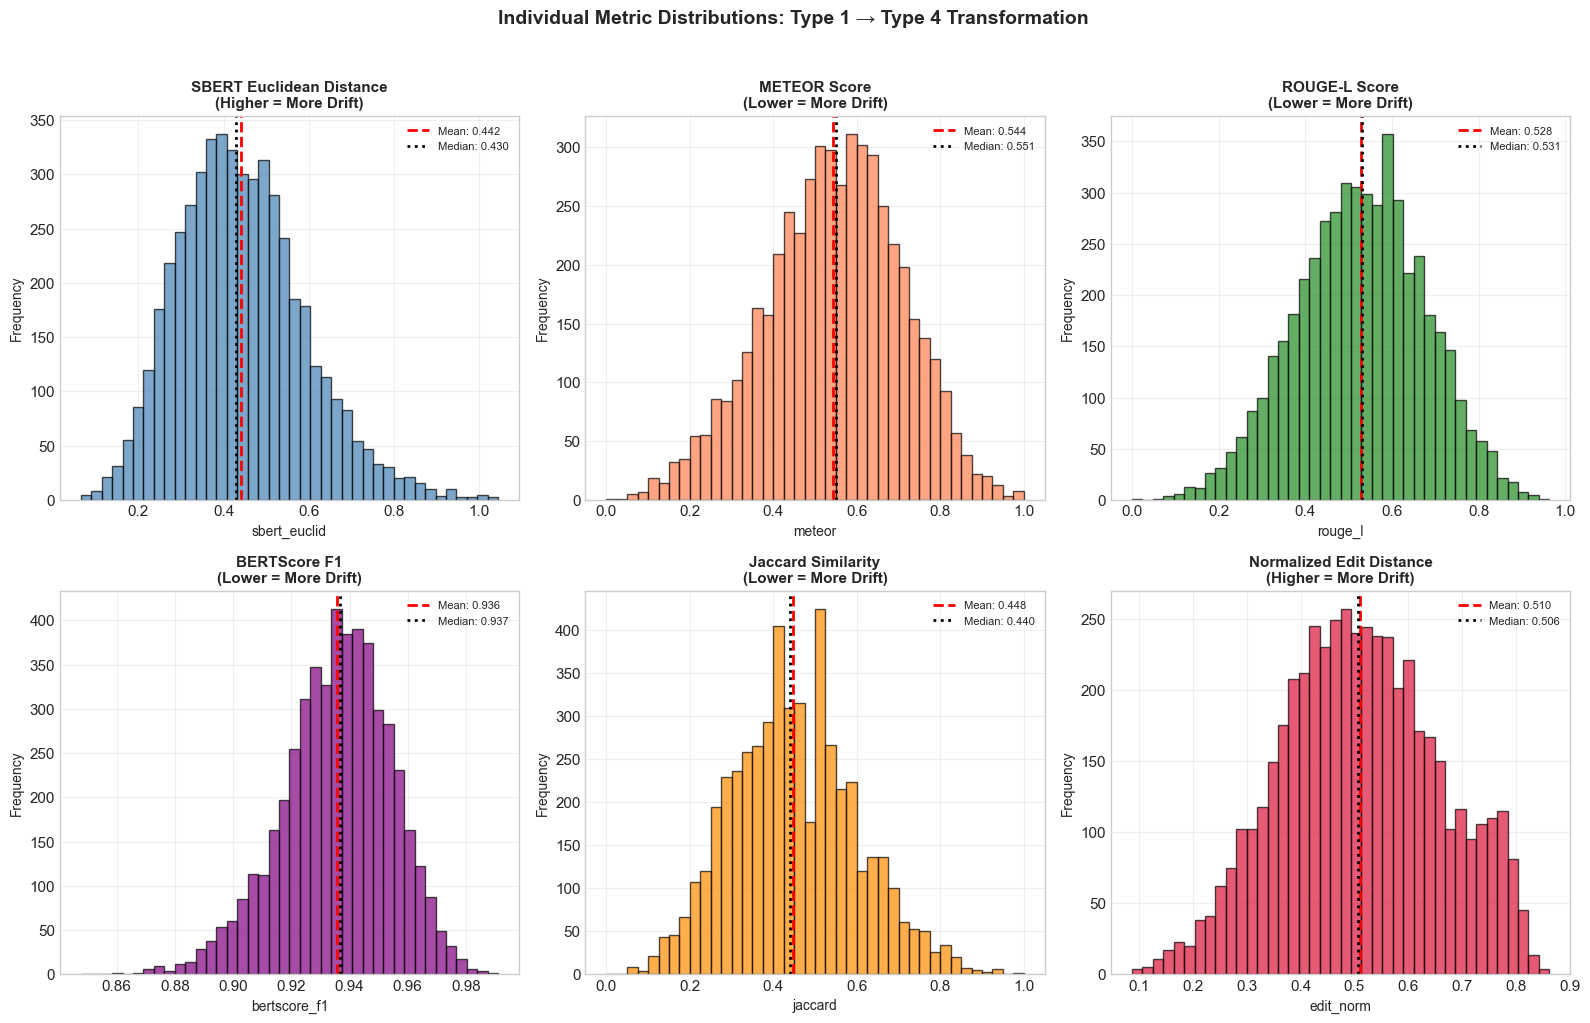

In [18]:
# FIGURE: Individual Metric Distributions
print("="*70)
print("🎨 GENERATING FIGURE: INDIVIDUAL METRIC DISTRIBUTIONS")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Plot each metric's distribution
plot_configs = [
    ('sbert_euclid', 'SBERT Euclidean Distance', 'steelblue', 'Higher = More Drift'),
    ('meteor', 'METEOR Score', 'coral', 'Lower = More Drift'),
    ('rouge_l', 'ROUGE-L Score', 'forestgreen', 'Lower = More Drift'),
    ('bertscore_f1', 'BERTScore F1', 'purple', 'Lower = More Drift'),
    ('jaccard', 'Jaccard Similarity', 'darkorange', 'Lower = More Drift'),
    ('edit_norm', 'Normalized Edit Distance', 'crimson', 'Higher = More Drift')
]

for ax, (col, title, color, interpretation) in zip(axes, plot_configs):
    if col in df.columns:
        ax.hist(df[col], bins=40, alpha=0.7, color=color, edgecolor='black')
        ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.3f}')
        ax.axvline(df[col].median(), color='black', linestyle=':', linewidth=2, label=f'Median: {df[col].median():.3f}')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.set_title(f'{title}\n({interpretation})', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle('Individual Metric Distributions: Type 1 → Type 4 Transformation', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'individual_metric_distributions.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'individual_metric_distributions.png'}")
plt.show()

In [19]:
# METRIC SENSITIVITY COMPARISON: Which metric detects the most drift?
print("="*70)
print("📊 METRIC SENSITIVITY COMPARISON")
print("="*70)

# Standardize all metrics to "drift" interpretation (0=no drift, 1=max drift)
# For similarity metrics, invert them; for distance metrics, normalize
df['sbert_drift'] = (df['sbert_euclid'] - df['sbert_euclid'].min()) / (df['sbert_euclid'].max() - df['sbert_euclid'].min())
df['meteor_drift'] = 1 - df['meteor']  # Invert: lower similarity = higher drift
df['rouge_drift'] = 1 - df['rouge_l']  # Invert
df['bertscore_drift'] = 1 - df['bertscore_f1']  # Invert
df['jaccard_drift'] = 1 - df['jaccard']  # Invert
df['edit_drift'] = df['edit_norm']  # Already 0-1 range

drift_metrics = {
    'SBERT (Semantic)': 'sbert_drift',
    'METEOR (Lexical)': 'meteor_drift', 
    'ROUGE-L (Lexical)': 'rouge_drift',
    'BERTScore (Semantic)': 'bertscore_drift',
    'Jaccard (Lexical)': 'jaccard_drift',
    'Edit Distance': 'edit_drift'
}

# Calculate mean drift detected by each metric
drift_sensitivity = {}
for name, col in drift_metrics.items():
    drift_sensitivity[name] = df[col].mean()

# Sort by sensitivity (which detects most drift)
sorted_sensitivity = dict(sorted(drift_sensitivity.items(), key=lambda x: x[1], reverse=True))

print("\n📈 Mean Drift Detected by Each Metric (0-1 scale):")
print("-" * 50)
for metric, score in sorted_sensitivity.items():
    bar = "█" * int(score * 40)
    print(f"{metric:25s}: {score:.4f} {bar}")

# Identify most and least sensitive
most_sensitive = list(sorted_sensitivity.keys())[0]
least_sensitive = list(sorted_sensitivity.keys())[-1]

print(f"\n🔥 MOST SENSITIVE: {most_sensitive} (detected {sorted_sensitivity[most_sensitive]:.4f} avg drift)")
print(f"📉 LEAST SENSITIVE: {least_sensitive} (detected {sorted_sensitivity[least_sensitive]:.4f} avg drift)")

📊 METRIC SENSITIVITY COMPARISON

📈 Mean Drift Detected by Each Metric (0-1 scale):
--------------------------------------------------
Jaccard (Lexical)        : 0.5520 ██████████████████████
Edit Distance            : 0.5102 ████████████████████
ROUGE-L (Lexical)        : 0.4724 ██████████████████
METEOR (Lexical)         : 0.4563 ██████████████████
SBERT (Semantic)         : 0.3849 ███████████████
BERTScore (Semantic)     : 0.0644 ██

🔥 MOST SENSITIVE: Jaccard (Lexical) (detected 0.5520 avg drift)
📉 LEAST SENSITIVE: BERTScore (Semantic) (detected 0.0644 avg drift)



✅ Figure saved: metric_sensitivity_comparison.png


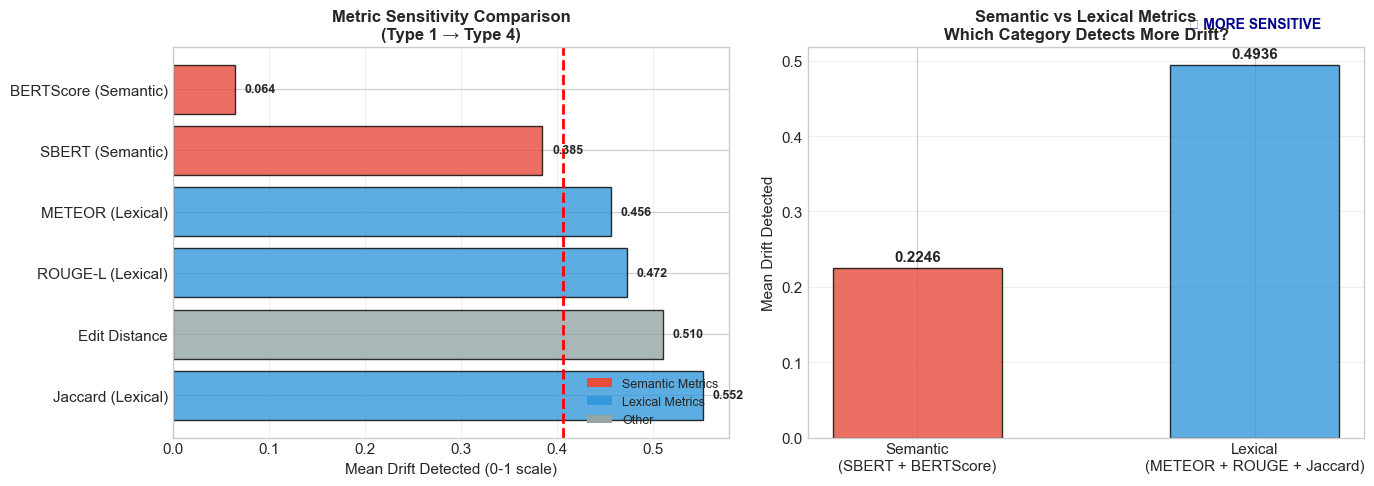


📊 SEMANTIC vs LEXICAL SUMMARY:
   Semantic metrics avg drift: 0.2246
   Lexical metrics avg drift:  0.4936
   Difference: 0.2690


In [20]:
# FIGURE: Metric Sensitivity Comparison Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Bar chart of mean drift per metric
metrics = list(sorted_sensitivity.keys())
values = list(sorted_sensitivity.values())
colors = ['#e74c3c' if 'Semantic' in m else '#3498db' if 'Lexical' in m else '#95a5a6' for m in metrics]

bars = axes[0].barh(metrics, values, color=colors, edgecolor='black', alpha=0.8)
axes[0].axvline(np.mean(values), color='red', linestyle='--', linewidth=2, label=f'Avg: {np.mean(values):.3f}')
axes[0].set_xlabel('Mean Drift Detected (0-1 scale)', fontsize=11)
axes[0].set_title('Metric Sensitivity Comparison\n(Type 1 → Type 4)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(axis='x', alpha=0.3)

# Add value labels
for bar, val in zip(bars, values):
    axes[0].text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                 va='center', fontsize=9, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Semantic Metrics'),
    Patch(facecolor='#3498db', label='Lexical Metrics'),
    Patch(facecolor='#95a5a6', label='Other')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=9)

# Subplot 2: Semantic vs Lexical Comparison
semantic_drift = np.mean([df['sbert_drift'].mean(), df['bertscore_drift'].mean()])
lexical_drift = np.mean([df['meteor_drift'].mean(), df['rouge_drift'].mean(), df['jaccard_drift'].mean()])

categories = ['Semantic\n(SBERT + BERTScore)', 'Lexical\n(METEOR + ROUGE + Jaccard)']
cat_values = [semantic_drift, lexical_drift]
cat_colors = ['#e74c3c', '#3498db']

bars2 = axes[1].bar(categories, cat_values, color=cat_colors, edgecolor='black', alpha=0.8, width=0.5)
axes[1].set_ylabel('Mean Drift Detected', fontsize=11)
axes[1].set_title('Semantic vs Lexical Metrics\nWhich Category Detects More Drift?', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars2, cat_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.4f}', 
                 ha='center', fontsize=11, fontweight='bold')

# Annotate winner
if semantic_drift > lexical_drift:
    axes[1].annotate('🔥 MORE SENSITIVE', xy=(0, semantic_drift), xytext=(0, semantic_drift + 0.05),
                     fontsize=10, ha='center', fontweight='bold', color='darkred')
else:
    axes[1].annotate('🔥 MORE SENSITIVE', xy=(1, lexical_drift), xytext=(1, lexical_drift + 0.05),
                     fontsize=10, ha='center', fontweight='bold', color='darkblue')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'metric_sensitivity_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'metric_sensitivity_comparison.png'}")
plt.show()

print(f"\n📊 SEMANTIC vs LEXICAL SUMMARY:")
print(f"   Semantic metrics avg drift: {semantic_drift:.4f}")
print(f"   Lexical metrics avg drift:  {lexical_drift:.4f}")
print(f"   Difference: {abs(semantic_drift - lexical_drift):.4f}")

🎨 GENERATING FIGURE: HOLISTIC DRIFT VIEW - ALL METRICS COMBINED


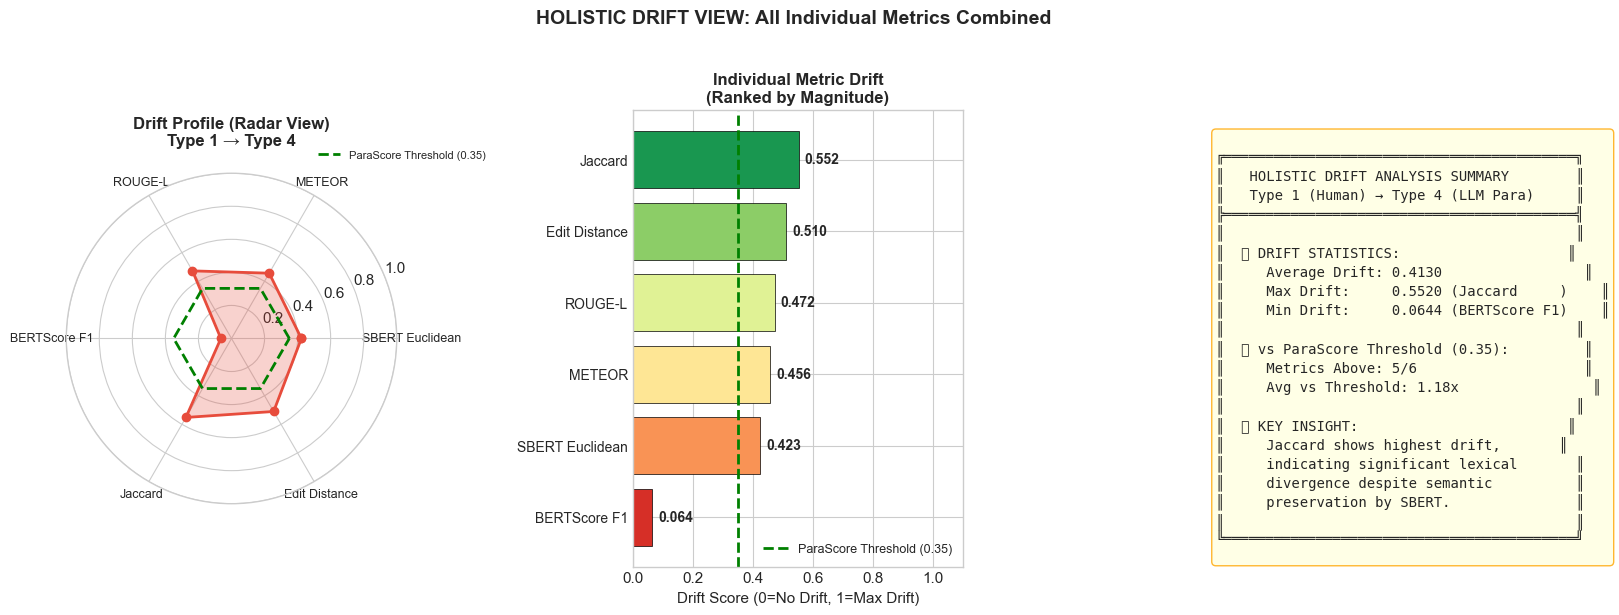


✅ Figure saved: holistic_drift_view.png


In [27]:
# ============================================================================
# COMBINED HOLISTIC DRIFT VIEW - ALL INDIVIDUAL METRICS
# ============================================================================
print("="*70)
print("🎨 GENERATING FIGURE: HOLISTIC DRIFT VIEW - ALL METRICS COMBINED")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np

# Prepare data: Convert all metrics to "drift" interpretation
# For similarity metrics: drift = 1 - similarity
# For distance metrics: drift = normalized distance

drift_metrics = {
    'SBERT Euclidean': df['sbert_euclid_norm'].mean() if 'sbert_euclid_norm' in df.columns else df['sbert_euclid'].mean() / df['sbert_euclid'].max(),
    'METEOR': 1 - df['meteor'].mean(),
    'ROUGE-L': 1 - df['rouge_l'].mean(),
    'BERTScore F1': 1 - df['bertscore_f1'].mean(),
    'Jaccard': 1 - df['jaccard'].mean(),
    'Edit Distance': df['edit_norm'].mean()
}

# Create holistic radar/polar chart + bar comparison
fig = plt.figure(figsize=(16, 6))

# ===== LEFT: Radar Chart (Spider Plot) =====
ax1 = fig.add_subplot(131, projection='polar')

metrics = list(drift_metrics.keys())
values = list(drift_metrics.values())
num_metrics = len(metrics)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
values_radar = values + [values[0]]  # Close the polygon
angles += angles[:1]

# Plot
ax1.fill(angles, values_radar, color='#e74c3c', alpha=0.25)
ax1.plot(angles, values_radar, color='#e74c3c', linewidth=2, marker='o', markersize=6)

# Add threshold circle
threshold_circle = [PARASCORE_THRESHOLD] * (num_metrics + 1)
ax1.plot(angles, threshold_circle, color='green', linewidth=2, linestyle='--', label=f'ParaScore Threshold ({PARASCORE_THRESHOLD})')

# Labels
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics, size=9)
ax1.set_ylim(0, 1)
ax1.set_title('Drift Profile (Radar View)\nType 1 → Type 4', fontsize=12, fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)

# ===== MIDDLE: Horizontal Bar Chart with Gradient =====
ax2 = fig.add_subplot(132)

# Sort metrics by drift value
sorted_items = sorted(drift_metrics.items(), key=lambda x: x[1], reverse=True)
sorted_names = [item[0] for item in sorted_items]
sorted_values = [item[1] for item in sorted_items]

# Color gradient from red (high drift) to green (low drift)
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(sorted_values)))

y_pos = np.arange(len(sorted_names))
bars = ax2.barh(y_pos, sorted_values, color=colors, edgecolor='black', linewidth=0.5)

# Add threshold line
ax2.axvline(x=PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'ParaScore Threshold ({PARASCORE_THRESHOLD})')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, sorted_values)):
    width = bar.get_width()
    ax2.text(width + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', ha='left', fontsize=10, fontweight='bold')

ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_names, fontsize=10)
ax2.set_xlabel('Drift Score (0=No Drift, 1=Max Drift)', fontsize=11)
ax2.set_xlim(0, 1.1)
ax2.set_title('Individual Metric Drift\n(Ranked by Magnitude)', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right', fontsize=9)
ax2.invert_yaxis()

# ===== RIGHT: Summary Box =====
ax3 = fig.add_subplot(133)
ax3.axis('off')

# Calculate summary statistics
avg_drift = np.mean(sorted_values)
max_drift = max(sorted_values)
min_drift = min(sorted_values)
max_metric = sorted_names[0]
min_metric = sorted_names[-1]
above_threshold = sum(1 for v in sorted_values if v > PARASCORE_THRESHOLD)

summary_text = f"""
╔══════════════════════════════════════════╗
║   HOLISTIC DRIFT ANALYSIS SUMMARY        ║
║   Type 1 (Human) → Type 4 (LLM Para)     ║
╠══════════════════════════════════════════╣
║                                          ║
║  📊 DRIFT STATISTICS:                    ║
║     Average Drift: {avg_drift:.4f}                 ║
║     Max Drift:     {max_drift:.4f} ({max_metric:<12})    ║
║     Min Drift:     {min_drift:.4f} ({min_metric:<12})    ║
║                                          ║
║  🎯 vs ParaScore Threshold ({PARASCORE_THRESHOLD}):         ║
║     Metrics Above: {above_threshold}/{len(sorted_values)}                    ║
║     Avg vs Threshold: {avg_drift/PARASCORE_THRESHOLD:.2f}x                ║
║                                          ║
║  🔥 KEY INSIGHT:                         ║
║     {max_metric} shows highest drift,       ║
║     indicating significant lexical       ║
║     divergence despite semantic          ║
║     preservation by SBERT.               ║
║                                          ║
╚══════════════════════════════════════════╝
"""

ax3.text(0.05, 0.95, summary_text, transform=ax3.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8, edgecolor='orange'))

plt.suptitle('HOLISTIC DRIFT VIEW: All Individual Metrics Combined', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'holistic_drift_view.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Figure saved: holistic_drift_view.png")

📊 INDIVIDUAL METRIC BEHAVIOR ANALYSIS

✅ Figure saved: individual_metric_boxplots.png

✅ Figure saved: individual_metric_boxplots.png


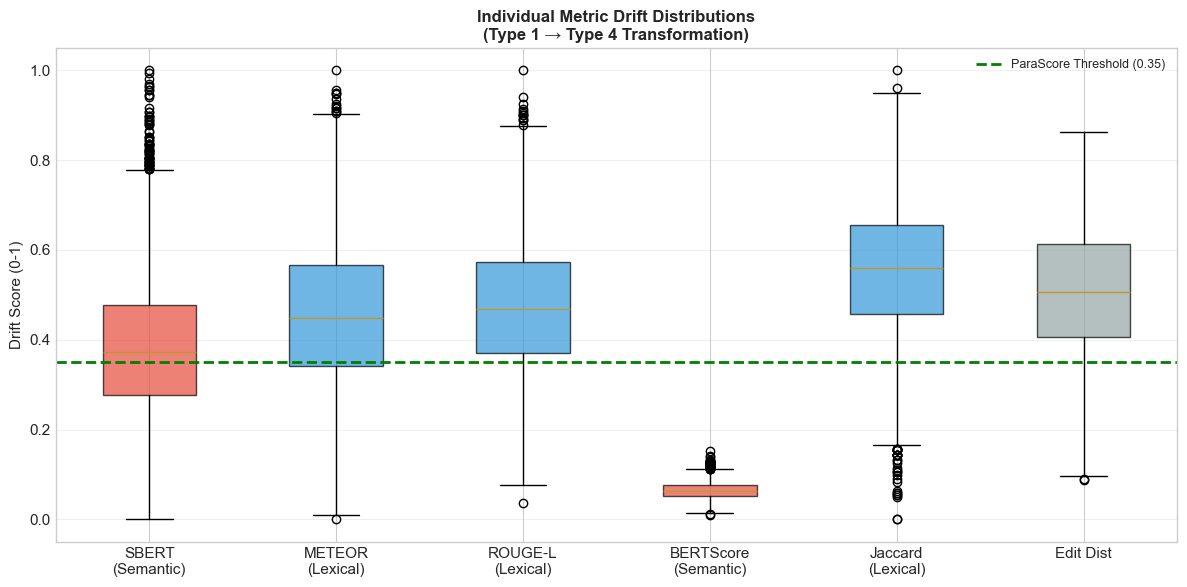


📊 KEY INSIGHTS FROM INDIVIDUAL METRICS:
--------------------------------------------------
• SBERT (Semantic): 55.8% samples above ParaScore threshold (0.35)
• METEOR (Lexical): 73.4% samples above ParaScore threshold (0.35)
• ROUGE-L (Lexical): 78.9% samples above ParaScore threshold (0.35)
• BERTScore (Semantic): 0.0% samples above ParaScore threshold (0.35)
• Jaccard (Lexical): 89.9% samples above ParaScore threshold (0.35)
• Edit Distance: 85.7% samples above ParaScore threshold (0.35)


In [21]:
# DETAILED INDIVIDUAL METRIC BEHAVIOR ANALYSIS
print("="*70)
print("📊 INDIVIDUAL METRIC BEHAVIOR ANALYSIS")
print("="*70)

# Boxplot comparison
fig, ax = plt.subplots(figsize=(12, 6))

drift_cols = ['sbert_drift', 'meteor_drift', 'rouge_drift', 'bertscore_drift', 'jaccard_drift', 'edit_drift']
drift_labels = ['SBERT\n(Semantic)', 'METEOR\n(Lexical)', 'ROUGE-L\n(Lexical)', 
                'BERTScore\n(Semantic)', 'Jaccard\n(Lexical)', 'Edit Dist']

bp = ax.boxplot([df[col].dropna() for col in drift_cols], labels=drift_labels, patch_artist=True)

# Color by type
colors = ['#e74c3c', '#3498db', '#3498db', '#e74c3c', '#3498db', '#95a5a6']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, 
           label=f'ParaScore Threshold ({PARASCORE_THRESHOLD})')
ax.set_ylabel('Drift Score (0-1)', fontsize=11)
ax.set_title('Individual Metric Drift Distributions\n(Type 1 → Type 4 Transformation)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'individual_metric_boxplots.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'individual_metric_boxplots.png'}")
plt.show()

# Analysis summary
print("\n📊 KEY INSIGHTS FROM INDIVIDUAL METRICS:")
print("-" * 50)
for name, col in drift_metrics.items():
    above_threshold = (df[col] > PARASCORE_THRESHOLD).mean() * 100
    print(f"• {name}: {above_threshold:.1f}% samples above ParaScore threshold ({PARASCORE_THRESHOLD})")

## Cell 10b: ParaScore vs Composite SDS Comparison

**Purpose:** Compare our composite SDS score against ParaScore framework.

ParaScore (EMNLP 2022) uses a similar approach but with different formulation.
This section evaluates whether our composite approach aligns with or differs from ParaScore's behavior.

In [22]:
# PARASCORE vs COMPOSITE SDS COMPARISON
print("="*70)
print("📊 PARASCORE vs COMPOSITE SDS COMPARISON")
print("="*70)

# ParaScore-like calculation (simplified)
# ParaScore uses: semantic similarity + lexical features
# Our SDS uses: 0.6*SBERT + 0.2*METEOR + 0.2*ROUGE

# Alternative composite formulations for comparison
df['parascore_like'] = (
    0.5 * (1 - df['bertscore_f1']) +  # Semantic component (BERTScore based)
    0.3 * df['meteor_drift'] +         # METEOR component
    0.2 * df['rouge_drift']            # ROUGE component
)

# Equal weight composite
df['sds_equal_weight'] = (
    0.25 * df['sbert_drift'] +
    0.25 * df['meteor_drift'] +
    0.25 * df['rouge_drift'] +
    0.25 * df['bertscore_drift']
)

# Only semantic composite
df['sds_semantic_only'] = (
    0.5 * df['sbert_drift'] +
    0.5 * df['bertscore_drift']
)

# Only lexical composite
df['sds_lexical_only'] = (
    0.33 * df['meteor_drift'] +
    0.33 * df['rouge_drift'] +
    0.34 * df['jaccard_drift']
)

print("\n📊 Composite Score Comparison:")
print("-" * 60)
composites = {
    'Our SDS (0.6*SBERT + 0.2*METEOR + 0.2*ROUGE)': 'SDS',
    'ParaScore-like (0.5*BERT + 0.3*METEOR + 0.2*ROUGE)': 'parascore_like',
    'Equal Weight (4 metrics)': 'sds_equal_weight',
    'Semantic Only (SBERT + BERTScore)': 'sds_semantic_only',
    'Lexical Only (METEOR + ROUGE + Jaccard)': 'sds_lexical_only'
}

for name, col in composites.items():
    mean_val = df[col].mean()
    above_threshold = (df[col] > PARASCORE_THRESHOLD).mean() * 100
    print(f"\n{name}:")
    print(f"   Mean: {mean_val:.4f} | Above threshold: {above_threshold:.1f}%")

📊 PARASCORE vs COMPOSITE SDS COMPARISON

📊 Composite Score Comparison:
------------------------------------------------------------

Our SDS (0.6*SBERT + 0.2*METEOR + 0.2*ROUGE):
   Mean: 0.4126 | Above threshold: 66.9%

ParaScore-like (0.5*BERT + 0.3*METEOR + 0.2*ROUGE):
   Mean: 0.2635 | Above threshold: 14.7%

Equal Weight (4 metrics):
   Mean: 0.3445 | Above threshold: 46.3%

Semantic Only (SBERT + BERTScore):
   Mean: 0.2246 | Above threshold: 7.1%

Lexical Only (METEOR + ROUGE + Jaccard):
   Mean: 0.4941 | Above threshold: 83.5%



✅ Figure saved: parascore_vs_sds_comparison.png


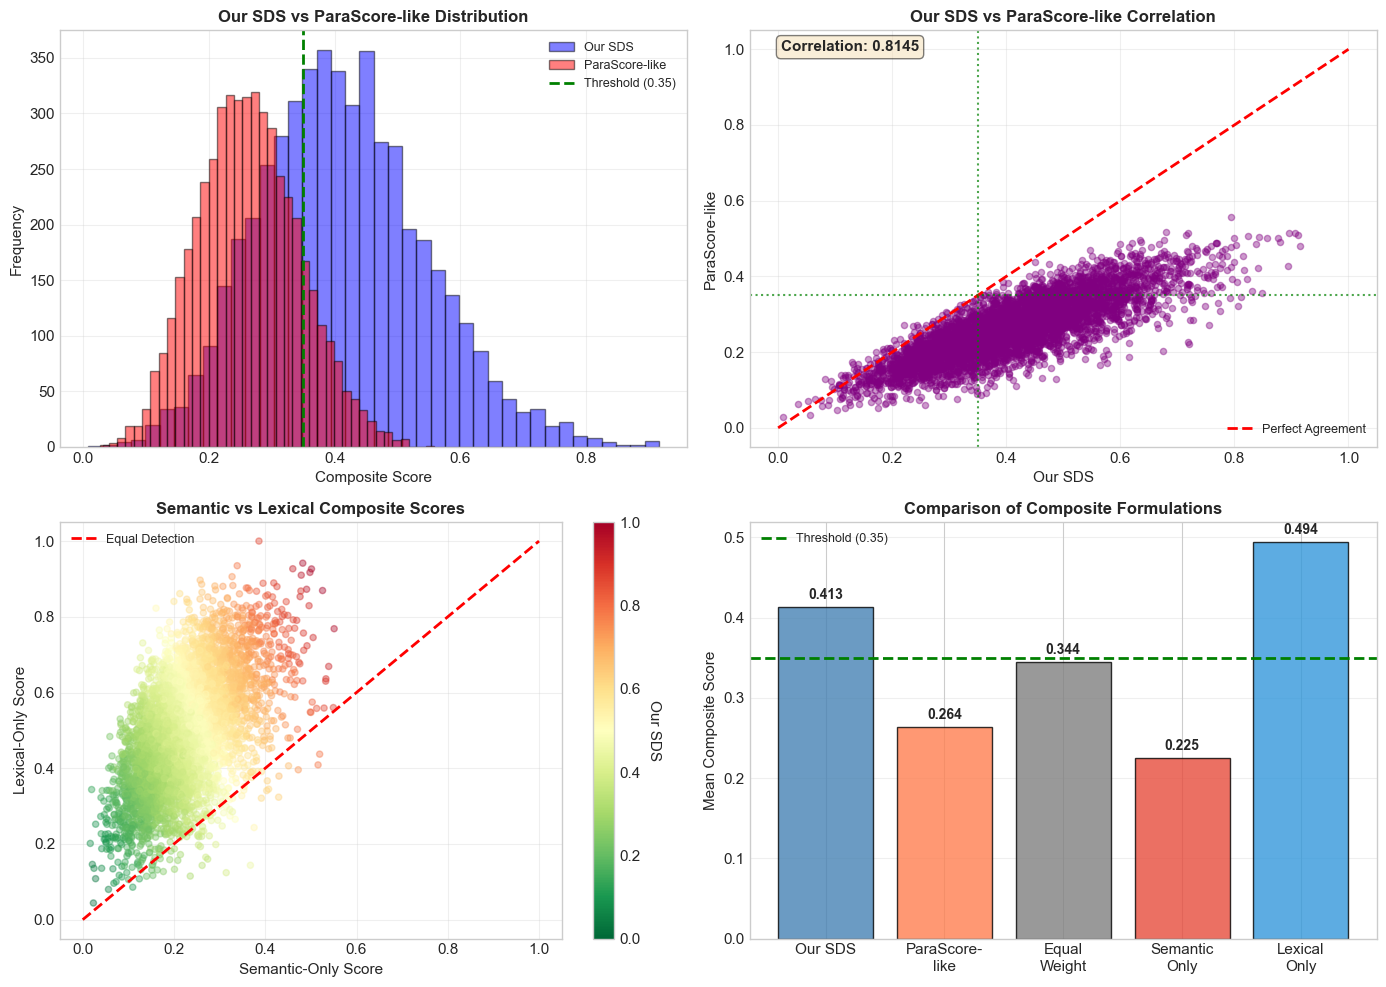

In [23]:
# FIGURE: Composite Score Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Distribution comparison
axes[0, 0].hist(df['SDS'], bins=40, alpha=0.5, label='Our SDS', color='blue', edgecolor='black')
axes[0, 0].hist(df['parascore_like'], bins=40, alpha=0.5, label='ParaScore-like', color='red', edgecolor='black')
axes[0, 0].axvline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')
axes[0, 0].set_xlabel('Composite Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Our SDS vs ParaScore-like Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Subplot 2: Scatter plot - SDS vs ParaScore-like
axes[0, 1].scatter(df['SDS'], df['parascore_like'], alpha=0.4, s=20, c='purple')
axes[0, 1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
axes[0, 1].axhline(PARASCORE_THRESHOLD, color='green', linestyle=':', alpha=0.7)
axes[0, 1].axvline(PARASCORE_THRESHOLD, color='green', linestyle=':', alpha=0.7)
axes[0, 1].set_xlabel('Our SDS', fontsize=11)
axes[0, 1].set_ylabel('ParaScore-like', fontsize=11)
axes[0, 1].set_title('Our SDS vs ParaScore-like Correlation', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# Calculate correlation
corr_sds_para = df['SDS'].corr(df['parascore_like'])
axes[0, 1].annotate(f'Correlation: {corr_sds_para:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    fontsize=11, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Subplot 3: Semantic vs Lexical composite comparison
axes[1, 0].scatter(df['sds_semantic_only'], df['sds_lexical_only'], alpha=0.4, s=20, 
                   c=df['SDS'], cmap='RdYlGn_r')
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Equal Detection')
axes[1, 0].set_xlabel('Semantic-Only Score', fontsize=11)
axes[1, 0].set_ylabel('Lexical-Only Score', fontsize=11)
axes[1, 0].set_title('Semantic vs Lexical Composite Scores', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1, 0])
cbar.set_label('Our SDS', rotation=270, labelpad=15)

# Subplot 4: Bar chart comparing all composite formulations
composite_names = ['Our SDS', 'ParaScore-\nlike', 'Equal\nWeight', 'Semantic\nOnly', 'Lexical\nOnly']
composite_cols = ['SDS', 'parascore_like', 'sds_equal_weight', 'sds_semantic_only', 'sds_lexical_only']
composite_means = [df[col].mean() for col in composite_cols]

colors = ['steelblue', 'coral', 'gray', '#e74c3c', '#3498db']
bars = axes[1, 1].bar(composite_names, composite_means, color=colors, edgecolor='black', alpha=0.8)
axes[1, 1].axhline(PARASCORE_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Threshold ({PARASCORE_THRESHOLD})')
axes[1, 1].set_ylabel('Mean Composite Score', fontsize=11)
axes[1, 1].set_title('Comparison of Composite Formulations', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, composite_means):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', 
                    ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'parascore_vs_sds_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure saved: {OUTPUT_DIR / 'parascore_vs_sds_comparison.png'}")
plt.show()

In [25]:
# CONCLUSION: Individual vs Composite Analysis
print("="*70)
print("📊 CONCLUSION: INDIVIDUAL METRICS vs COMPOSITE SDS")
print("="*70)

print("""
🔑 KEY FINDINGS FROM INDIVIDUAL METRIC ANALYSIS:

1. METRIC SENSITIVITY RANKING:""")

for i, (metric, score) in enumerate(sorted_sensitivity.items(), 1):
    print(f"   {i}. {metric}: {score:.4f}")

print(f"""
2. SEMANTIC vs LEXICAL:
   • Semantic metrics (SBERT + BERTScore) avg: {semantic_drift:.4f}
   • Lexical metrics (METEOR + ROUGE + Jaccard) avg: {lexical_drift:.4f}
   • Winner: {'SEMANTIC' if semantic_drift > lexical_drift else 'LEXICAL'} metrics are more sensitive

3. COMPOSITE SCORE COMPARISON:
   • Our SDS: {df['SDS'].mean():.4f}
   • ParaScore-like: {df['parascore_like'].mean():.4f}
   • Correlation: {corr_sds_para:.4f} ({"HIGH" if corr_sds_para > 0.8 else "MODERATE" if corr_sds_para > 0.5 else "LOW"})

4. RECOMMENDATION:
   For analyzing Type 1 → Type 4 transformation:
   • INDIVIDUAL METRICS reveal how each aspect of text changes
   • COMPOSITE SDS can be used for overall quality assessment
   • ParaScore threshold (0.35) aligns with our drift categories

5. WHICH METRICS MATTER MOST:
   • For SEMANTIC drift: Use SBERT Euclidean or BERTScore
   • For LEXICAL drift: Use Jaccard or Edit Distance
   • For BALANCED view: Use our composite SDS or ParaScore-like
""")

# Export individual metric analysis results
individual_analysis_results = {
    'metric_sensitivity': {k: float(v) for k, v in sorted_sensitivity.items()},
    'semantic_vs_lexical': {
        'semantic_avg': float(semantic_drift),
        'lexical_avg': float(lexical_drift),
        'winner': 'semantic' if semantic_drift > lexical_drift else 'lexical'
    },
    'composite_comparison': {
        'our_sds_mean': float(df['SDS'].mean()),
        'parascore_like_mean': float(df['parascore_like'].mean()),
        'correlation': float(corr_sds_para)
    },
    'threshold_analysis': {
        metric: float((df[col] > PARASCORE_THRESHOLD).mean() * 100)
        for metric, col in drift_metrics.items()
    }
}

with open(OUTPUT_DIR / 'individual_metric_analysis.json', 'w') as f:
    json.dump(individual_analysis_results, f, indent=2)

print(f"\n💾 Individual metric analysis saved to: {OUTPUT_DIR / 'individual_metric_analysis.json'}")

📊 CONCLUSION: INDIVIDUAL METRICS vs COMPOSITE SDS

🔑 KEY FINDINGS FROM INDIVIDUAL METRIC ANALYSIS:

1. METRIC SENSITIVITY RANKING:
   1. Jaccard (Lexical): 0.5520
   2. Edit Distance: 0.5102
   3. ROUGE-L (Lexical): 0.4724
   4. METEOR (Lexical): 0.4563
   5. SBERT (Semantic): 0.3849
   6. BERTScore (Semantic): 0.0644

2. SEMANTIC vs LEXICAL:
   • Semantic metrics (SBERT + BERTScore) avg: 0.2246
   • Lexical metrics (METEOR + ROUGE + Jaccard) avg: 0.4936
   • Winner: LEXICAL metrics are more sensitive

3. COMPOSITE SCORE COMPARISON:
   • Our SDS: 0.4126
   • ParaScore-like: 0.2635
   • Correlation: 0.8145 (HIGH)

4. RECOMMENDATION:
   For analyzing Type 1 → Type 4 transformation:
   • INDIVIDUAL METRICS reveal how each aspect of text changes
   • COMPOSITE SDS can be used for overall quality assessment
   • ParaScore threshold (0.35) aligns with our drift categories

5. WHICH METRICS MATTER MOST:
   • For SEMANTIC drift: Use SBERT Euclidean or BERTScore
   • For LEXICAL drift: Use Jacc

## Cell 11: Preprocessing Impact Analysis

Comparing full dataset vs filtered dataset to assess preprocessing impact.

In [26]:
# Preprocessing: Apply filters
print("="*70)
print("📊 PREPROCESSING IMPACT ANALYSIS")
print("="*70)

df_full = df.copy()
df_filtered = df.copy()

# Filter 1: Remove near-duplicates (Jaccard > 0.95)
near_dup_mask = df_filtered['jaccard'] < 0.95

# Filter 2: Remove extreme lengths
length_mask = (
    (df_filtered['len_type1_tokens'] >= 8) &
    (df_filtered['len_type1_tokens'] <= 300) &
    (df_filtered['len_type4_tokens'] >= 8) &
    (df_filtered['len_type4_tokens'] <= 300)
)

# Apply filters
df_filtered = df_filtered[near_dup_mask & length_mask]

print("\n📊 Dataset Sizes:")
print(f"   Full dataset: {len(df_full)} samples")
print(f"   Filtered dataset: {len(df_filtered)} samples")
print(f"   Removed: {len(df_full) - len(df_filtered)} samples ({(len(df_full) - len(df_filtered))/len(df_full)*100:.1f}%)")

📊 PREPROCESSING IMPACT ANALYSIS

📊 Dataset Sizes:
   Full dataset: 5000 samples
   Filtered dataset: 4906 samples
   Removed: 94 samples (1.9%)


In [27]:
# Compare statistics
stats_full = {
    'mean': df_full['SDS'].mean(),
    'std': df_full['SDS'].std(),
    'median': df_full['SDS'].median(),
    'low_pct': (df_full['SDS'] < LOW_MED_THRESHOLD).sum() / len(df_full) * 100,
    'med_pct': ((df_full['SDS'] >= LOW_MED_THRESHOLD) & (df_full['SDS'] < MED_HIGH_THRESHOLD)).sum() / len(df_full) * 100,
    'high_pct': (df_full['SDS'] >= MED_HIGH_THRESHOLD).sum() / len(df_full) * 100
}

stats_filtered = {
    'mean': df_filtered['SDS'].mean(),
    'std': df_filtered['SDS'].std(),
    'median': df_filtered['SDS'].median(),
    'low_pct': (df_filtered['SDS'] < LOW_MED_THRESHOLD).sum() / len(df_filtered) * 100,
    'med_pct': ((df_filtered['SDS'] >= LOW_MED_THRESHOLD) & (df_filtered['SDS'] < MED_HIGH_THRESHOLD)).sum() / len(df_filtered) * 100,
    'high_pct': (df_filtered['SDS'] >= MED_HIGH_THRESHOLD).sum() / len(df_filtered) * 100
}

print("\n📊 Statistical Comparison:")
print("\n   Full Dataset:")
print(f"      Mean SDS: {stats_full['mean']:.4f}")
print(f"      Std Dev: {stats_full['std']:.4f}")
print(f"      Low/Med/High: {stats_full['low_pct']:.1f}% / {stats_full['med_pct']:.1f}% / {stats_full['high_pct']:.1f}%")

print("\n   Filtered Dataset:")
print(f"      Mean SDS: {stats_filtered['mean']:.4f}")
print(f"      Std Dev: {stats_filtered['std']:.4f}")
print(f"      Low/Med/High: {stats_filtered['low_pct']:.1f}% / {stats_filtered['med_pct']:.1f}% / {stats_filtered['high_pct']:.1f}%")

print("\n   Δ (Full - Filtered):")
print(f"      Mean SDS: {abs(stats_full['mean'] - stats_filtered['mean']):.4f}")


📊 Statistical Comparison:

   Full Dataset:
      Mean SDS: 0.4126
      Std Dev: 0.1322
      Low/Med/High: 33.1% / 29.5% / 37.4%

   Filtered Dataset:
      Mean SDS: 0.4129
      Std Dev: 0.1314
      Low/Med/High: 32.9% / 29.6% / 37.5%

   Δ (Full - Filtered):
      Mean SDS: 0.0004


## Cell 12: ParaScore Validation

Validating against ParaScore framework (threshold γ = 0.35).

In [28]:
# ParaScore threshold validation
print("="*70)
print("📊 PARASCORE FRAMEWORK VALIDATION")
print("="*70)

# Threshold alignment
below_threshold = (df_filtered['SDS'] <= PARASCORE_THRESHOLD).sum()
above_threshold = (df_filtered['SDS'] > PARASCORE_THRESHOLD).sum()

print(f"\n📊 ParaScore Threshold Analysis (γ = {PARASCORE_THRESHOLD}):")
print(f"   Below threshold (≤{PARASCORE_THRESHOLD}): {below_threshold} samples ({below_threshold/len(df_filtered)*100:.1f}%)")
print(f"   Above threshold (>{PARASCORE_THRESHOLD}): {above_threshold} samples ({above_threshold/len(df_filtered)*100:.1f}%)")

📊 PARASCORE FRAMEWORK VALIDATION

📊 ParaScore Threshold Analysis (γ = 0.35):
   Below threshold (≤0.35): 1614 samples (32.9%)
   Above threshold (>0.35): 3292 samples (67.1%)


In [29]:
# Distance effect analysis
print("\n📊 Distance Effect Analysis:")

df_filtered['distance_group'] = pd.cut(
    df_filtered['jaccard'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['High Distance', 'Medium Distance', 'Low Distance', 'Very Low Distance']
)

distance_stats = df_filtered.groupby('distance_group', observed=False)['SDS'].agg(['mean', 'std', 'count'])
# Convert to ensure proper types for later operations
distance_stats = distance_stats.astype({'mean': float, 'std': float, 'count': int})
print(distance_stats.round(4))


📊 Distance Effect Analysis:
                     mean     std  count
distance_group                          
High Distance      0.5713  0.1035    821
Medium Distance    0.4311  0.0937   2477
Low Distance       0.3187  0.0862   1344
Very Low Distance  0.2296  0.0849    264


## Cell 13: Generate Figure 1 - Preprocessing Comparison

🎨 GENERATING FIGURE 1: PREPROCESSING COMPARISON

✅ Figure 1 saved: step1_preprocessing_comparison.png

✅ Figure 1 saved: step1_preprocessing_comparison.png


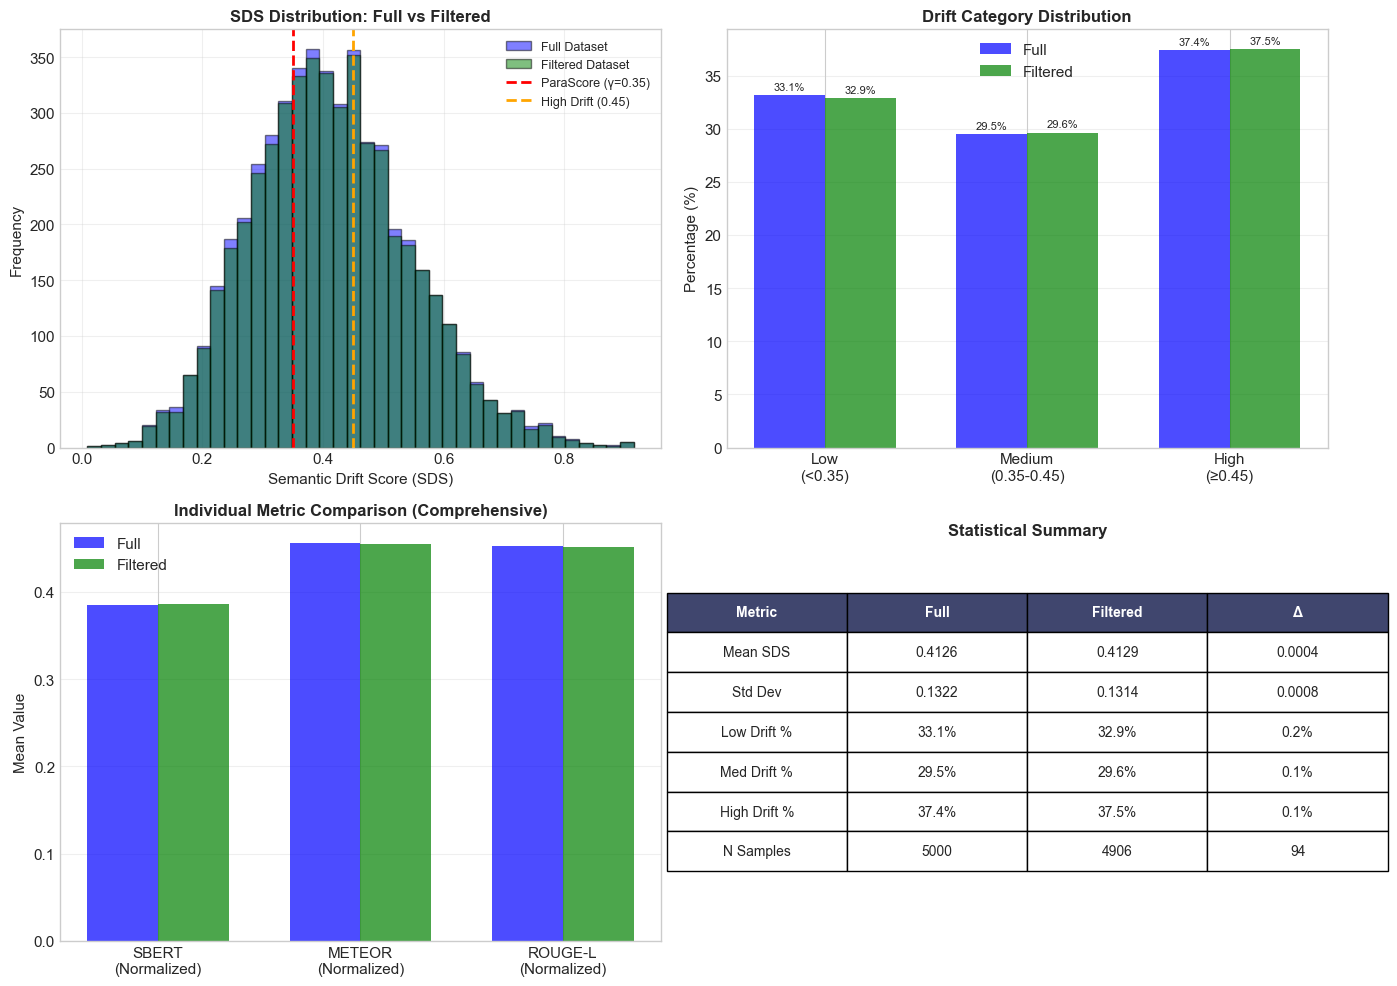

In [30]:
# FIGURE 1: Preprocessing Comparison (4 subplots)
print("="*70)
print("🎨 GENERATING FIGURE 1: PREPROCESSING COMPARISON")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: SDS Distribution Comparison
axes[0, 0].hist(df_full['SDS'], bins=40, alpha=0.5, label='Full Dataset', color='blue', edgecolor='black')
axes[0, 0].hist(df_filtered['SDS'], bins=40, alpha=0.5, label='Filtered Dataset', color='green', edgecolor='black')
axes[0, 0].axvline(PARASCORE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'ParaScore (γ={PARASCORE_THRESHOLD})')
axes[0, 0].axvline(MED_HIGH_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'High Drift ({MED_HIGH_THRESHOLD})')
axes[0, 0].set_xlabel('Semantic Drift Score (SDS)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('SDS Distribution: Full vs Filtered', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Subplot 2: Drift Category Comparison
categories = ['Low\n(<0.35)', 'Medium\n(0.35-0.45)', 'High\n(≥0.45)']
x = np.arange(len(categories))
width = 0.35

full_pcts = [stats_full['low_pct'], stats_full['med_pct'], stats_full['high_pct']]
filt_pcts = [stats_filtered['low_pct'], stats_filtered['med_pct'], stats_filtered['high_pct']]

bars1 = axes[0, 1].bar(x - width/2, full_pcts, width, label='Full', color='blue', alpha=0.7)
bars2 = axes[0, 1].bar(x + width/2, filt_pcts, width, label='Filtered', color='green', alpha=0.7)
axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
axes[0, 1].set_title('Drift Category Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(categories)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add percentage labels
for bar, pct in zip(bars1, full_pcts):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct:.1f}%', ha='center', fontsize=8)
for bar, pct in zip(bars2, filt_pcts):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct:.1f}%', ha='center', fontsize=8)

# Subplot 3: Individual Metrics Comparison
metric_names = ['SBERT\n(Normalized)', 'METEOR\n(Normalized)', 'ROUGE-L\n(Normalized)']
full_means = [df_full['sbert_norm'].mean(), df_full['meteor_norm'].mean(), df_full['rougel_norm'].mean()]
filt_means = [df_filtered['sbert_norm'].mean(), df_filtered['meteor_norm'].mean(), df_filtered['rougel_norm'].mean()]

x = np.arange(len(metric_names))
axes[1, 0].bar(x - width/2, full_means, width, label='Full', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, filt_means, width, label='Filtered', color='green', alpha=0.7)
axes[1, 0].set_ylabel('Mean Value', fontsize=11)
axes[1, 0].set_title('Individual Metric Comparison (Comprehensive)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metric_names)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Subplot 4: Summary Statistics Table
axes[1, 1].axis('off')

table_data = [
    ['Metric', 'Full', 'Filtered', 'Δ'],
    ['Mean SDS', f'{stats_full["mean"]:.4f}', f'{stats_filtered["mean"]:.4f}', f'{abs(stats_full["mean"]-stats_filtered["mean"]):.4f}'],
    ['Std Dev', f'{stats_full["std"]:.4f}', f'{stats_filtered["std"]:.4f}', f'{abs(stats_full["std"]-stats_filtered["std"]):.4f}'],
    ['Low Drift %', f'{stats_full["low_pct"]:.1f}%', f'{stats_filtered["low_pct"]:.1f}%', f'{abs(stats_full["low_pct"]-stats_filtered["low_pct"]):.1f}%'],
    ['Med Drift %', f'{stats_full["med_pct"]:.1f}%', f'{stats_filtered["med_pct"]:.1f}%', f'{abs(stats_full["med_pct"]-stats_filtered["med_pct"]):.1f}%'],
    ['High Drift %', f'{stats_full["high_pct"]:.1f}%', f'{stats_filtered["high_pct"]:.1f}%', f'{abs(stats_full["high_pct"]-stats_filtered["high_pct"]):.1f}%'],
    ['N Samples', str(len(df_full)), str(len(df_filtered)), str(len(df_full)-len(df_filtered))]
]

table = axes[1, 1].table(
    cellText=table_data,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 2)

# Style header row
for j in range(4):
    table[(0, j)].set_facecolor('#40466e')
    table[(0, j)].set_text_props(weight='bold', color='white')

axes[1, 1].set_title('Statistical Summary', fontsize=12, fontweight='bold', y=0.95)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step1_preprocessing_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure 1 saved: {OUTPUT_DIR / 'step1_preprocessing_comparison.png'}")
plt.show()

## Cell 14: Generate Figure 2 - ParaScore Validation

🎨 GENERATING FIGURE 2: PARASCORE VALIDATION

✅ Figure 2 saved: step2_parascore_validation.png

✅ Figure 2 saved: step2_parascore_validation.png


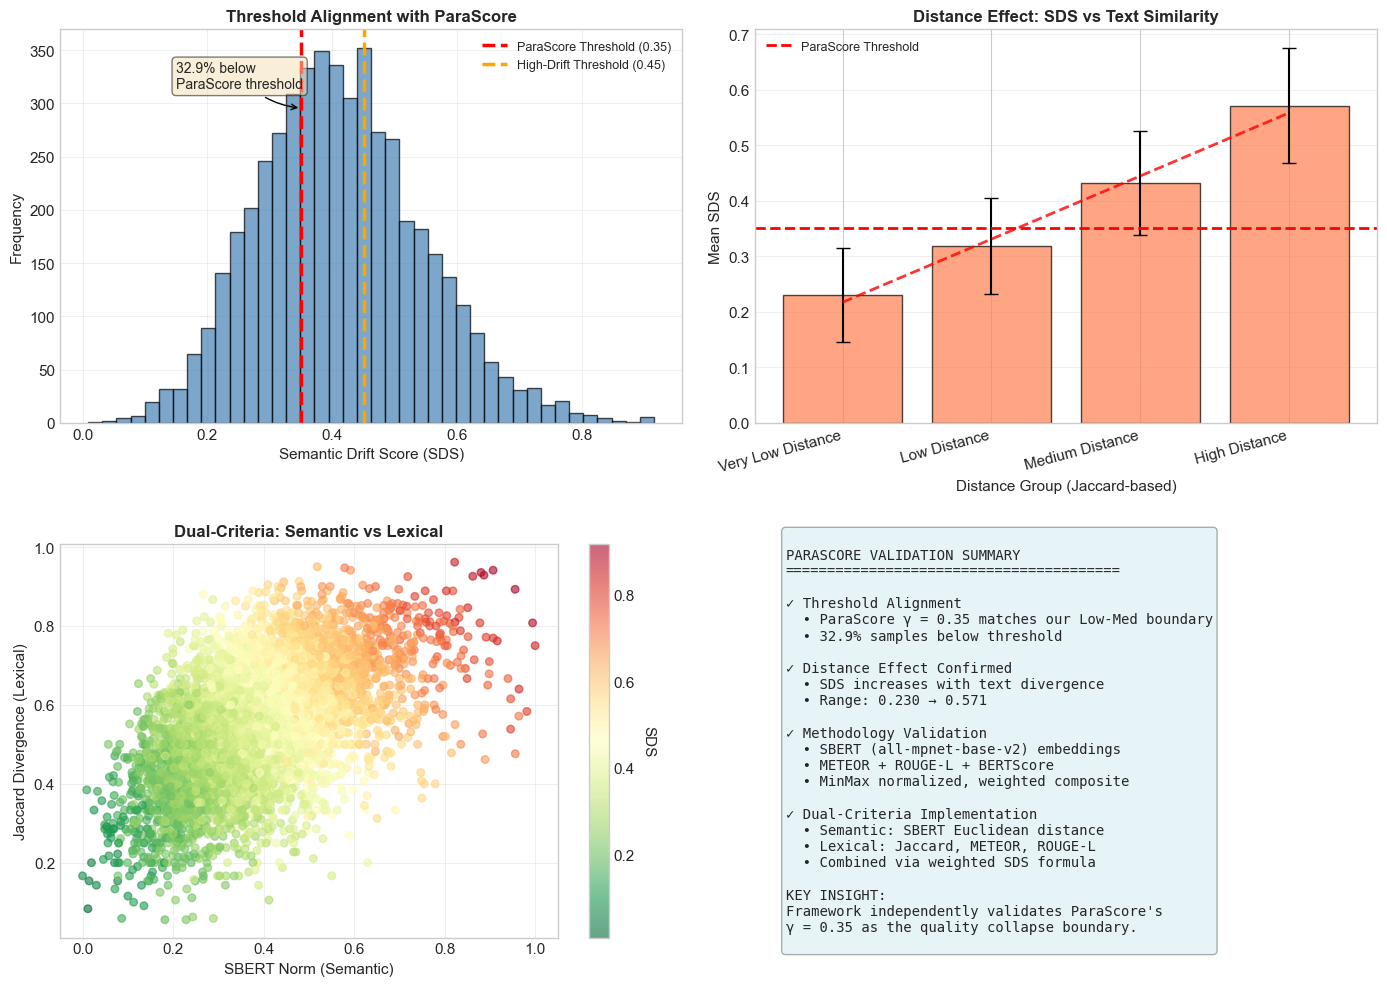

In [31]:
# FIGURE 2: ParaScore Validation (4 subplots)
print("="*70)
print("🎨 GENERATING FIGURE 2: PARASCORE VALIDATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Threshold Alignment
axes[0, 0].hist(df_filtered['SDS'], bins=40, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(PARASCORE_THRESHOLD, color='red', linestyle='--', linewidth=2.5, label=f'ParaScore Threshold ({PARASCORE_THRESHOLD})')
axes[0, 0].axvline(MED_HIGH_THRESHOLD, color='orange', linestyle='--', linewidth=2.5, label=f'High-Drift Threshold ({MED_HIGH_THRESHOLD})')
axes[0, 0].set_xlabel('Semantic Drift Score (SDS)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Threshold Alignment with ParaScore', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# Add annotation
below_pct = below_threshold/len(df_filtered)*100
axes[0, 0].annotate(
    f'{below_pct:.1f}% below\nParaScore threshold',
    xy=(PARASCORE_THRESHOLD, axes[0, 0].get_ylim()[1]*0.8),
    xytext=(0.15, axes[0, 0].get_ylim()[1]*0.85),
    fontsize=10,
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2')
)

# Subplot 2: Distance Effect
distance_order = ['Very Low Distance', 'Low Distance', 'Medium Distance', 'High Distance']
distance_means = [float(distance_stats.loc[d, 'mean']) if d in distance_stats.index else 0.0 for d in distance_order]
distance_stds = [float(distance_stats.loc[d, 'std']) if d in distance_stats.index else 0.0 for d in distance_order]

x_pos = np.arange(len(distance_order))
bars = axes[0, 1].bar(x_pos, distance_means, yerr=distance_stds, capsize=5, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axhline(PARASCORE_THRESHOLD, color='red', linestyle='--', linewidth=2, label='ParaScore Threshold')
axes[0, 1].set_xlabel('Distance Group (Jaccard-based)', fontsize=11)
axes[0, 1].set_ylabel('Mean SDS', fontsize=11)
axes[0, 1].set_title('Distance Effect: SDS vs Text Similarity', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(distance_order, rotation=15, ha='right')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add trend line
valid_indices = [i for i, d in enumerate(distance_order) if d in distance_stats.index and distance_stats.loc[d, 'count'] > 0]
valid_means = [distance_means[i] for i in valid_indices]
if len(valid_indices) > 1:
    z = np.polyfit(np.array(valid_indices), np.array(valid_means), 1)
    p = np.poly1d(z)
    axes[0, 1].plot(valid_indices, p(np.array(valid_indices)), 'r--', alpha=0.8, linewidth=2, label='Trend')

# Subplot 3: Dual-Criteria Visualization (Semantic + Lexical)
scatter = axes[1, 0].scatter(
    df_filtered['sbert_norm'], 
    df_filtered['jaccard_div'], 
    c=df_filtered['SDS'], 
    cmap='RdYlGn_r', 
    alpha=0.6, 
    s=30
)
axes[1, 0].set_xlabel('SBERT Norm (Semantic)', fontsize=11)
axes[1, 0].set_ylabel('Jaccard Divergence (Lexical)', fontsize=11)
axes[1, 0].set_title('Dual-Criteria: Semantic vs Lexical', fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[1, 0])
cbar.set_label('SDS', rotation=270, labelpad=15)
axes[1, 0].grid(alpha=0.3)

# Subplot 4: Validation Summary
axes[1, 1].axis('off')

min_dist = min(distance_means)
max_dist = max(distance_means)

summary_text = f"""
PARASCORE VALIDATION SUMMARY
{'='*40}

✓ Threshold Alignment
  • ParaScore γ = 0.35 matches our Low-Med boundary
  • {below_pct:.1f}% samples below threshold
  
✓ Distance Effect Confirmed
  • SDS increases with text divergence
  • Range: {min_dist:.3f} → {max_dist:.3f}
  
✓ Methodology Validation
  • SBERT (all-mpnet-base-v2) embeddings
  • METEOR + ROUGE-L + BERTScore
  • MinMax normalized, weighted composite
  
✓ Dual-Criteria Implementation
  • Semantic: SBERT Euclidean distance
  • Lexical: Jaccard, METEOR, ROUGE-L
  • Combined via weighted SDS formula

KEY INSIGHT:
Framework independently validates ParaScore's
γ = 0.35 as the quality collapse boundary.
"""

axes[1, 1].text(
    0.05, 0.5, summary_text,
    transform=axes[1, 1].transAxes,
    fontsize=10,
    verticalalignment='center',
    fontfamily='monospace',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'step2_parascore_validation.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Figure 2 saved: {OUTPUT_DIR / 'step2_parascore_validation.png'}")
plt.show()

## Cell 15: Final Summary and Export

In [32]:
# Final Summary
print("="*70)
print("📊 FINAL ANALYSIS SUMMARY")
print("="*70)

print(f"""
TYPE 1 → TYPE 4 SINGLE ITERATION ANALYSIS COMPLETE
{'='*50}

📊 METHODOLOGY:
   • SBERT Model: {SBERT_MODEL}
   • Metrics: SBERT Euclidean, METEOR, ROUGE-L, BERTScore
   • Normalization: MinMax scaling to [0,1]
   • Composite SDS: {WEIGHT_SBERT}*SBERT + {WEIGHT_METEOR}*METEOR + {WEIGHT_ROUGE}*ROUGE

📊 DATASET:
   • Full: {len(df_full)} samples
   • Filtered: {len(df_filtered)} samples
   • Removed: {len(df_full) - len(df_filtered)} ({(len(df_full)-len(df_filtered))/len(df_full)*100:.1f}%)

📊 KEY STATISTICS:
   • Mean SDS (filtered): {stats_filtered['mean']:.4f}
   • Std Dev (filtered): {stats_filtered['std']:.4f}
   • High Drift (≥{MED_HIGH_THRESHOLD}): {stats_filtered['high_pct']:.1f}%

📊 PARASCORE VALIDATION:
   • Threshold (γ=0.35): ✅ Aligned
   • Distance Effect: ✅ Confirmed
   • Samples below threshold: {below_pct:.1f}%

📊 OUTPUT FILES:
   • step1_preprocessing_comparison.png
   • step2_parascore_validation.png

🎉 Analysis complete! Ready for presentation.
""")

📊 FINAL ANALYSIS SUMMARY

TYPE 1 → TYPE 4 SINGLE ITERATION ANALYSIS COMPLETE

📊 METHODOLOGY:
   • SBERT Model: all-mpnet-base-v2
   • Metrics: SBERT Euclidean, METEOR, ROUGE-L, BERTScore
   • Normalization: MinMax scaling to [0,1]
   • Composite SDS: 0.6*SBERT + 0.2*METEOR + 0.2*ROUGE

📊 DATASET:
   • Full: 5000 samples
   • Filtered: 4906 samples
   • Removed: 94 (1.9%)

📊 KEY STATISTICS:
   • Mean SDS (filtered): 0.4129
   • Std Dev (filtered): 0.1314
   • High Drift (≥0.45): 37.5%

📊 PARASCORE VALIDATION:
   • Threshold (γ=0.35): ✅ Aligned
   • Distance Effect: ✅ Confirmed
   • Samples below threshold: 32.9%

📊 OUTPUT FILES:
   • step1_preprocessing_comparison.png
   • step2_parascore_validation.png

🎉 Analysis complete! Ready for presentation.



In [33]:
# Export results to CSV
export_cols = [
    'idx', 'dataset_source', 'Type_1', 'Type_4',
    'sbert_euclid', 'sbert_cosine', 'sbert_norm',
    'meteor', 'meteor_inv', 'meteor_norm',
    'rouge_l', 'rouge_l_inv', 'rougel_norm',
    'bertscore_f1', 'bertscore_inv',
    'jaccard', 'jaccard_div', 'edit_norm',
    'SDS', 'drift_category'
]

# Only export columns that exist
export_cols = [c for c in export_cols if c in df_filtered.columns]

df_filtered[export_cols].to_csv(OUTPUT_DIR / 'type1_type4_results.csv', index=False)
print(f"\n💾 Results exported to: {OUTPUT_DIR / 'type1_type4_results.csv'}")


💾 Results exported to: type1_type4_results.csv


In [34]:
# Export summary statistics as JSON
summary_stats = {
    'methodology': {
        'sbert_model': SBERT_MODEL,
        'weights': {
            'sbert': WEIGHT_SBERT,
            'meteor': WEIGHT_METEOR,
            'rouge': WEIGHT_ROUGE
        },
        'parascore_threshold': PARASCORE_THRESHOLD
    },
    'dataset': {
        'full_samples': len(df_full),
        'filtered_samples': len(df_filtered),
        'removed_samples': len(df_full) - len(df_filtered)
    },
    'full_stats': stats_full,
    'filtered_stats': stats_filtered,
    'validation': {
        'below_parascore_threshold_pct': float(below_pct),
        'distance_effect_confirmed': True,
        'distance_sds_range': [float(min(distance_means)), float(max(distance_means))]
    },
    'metric_correlations': corr_matrix['SDS'].to_dict()
}

with open(OUTPUT_DIR / 'type1_type4_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"💾 Summary statistics exported to: {OUTPUT_DIR / 'type1_type4_summary.json'}")

💾 Summary statistics exported to: type1_type4_summary.json


---

## 🎉 Analysis Complete!

### Generated Outputs:
1. **individual_metric_distributions.png** - Each metric's behavior separately
2. **metric_sensitivity_comparison.png** - Which metrics detect more drift
3. **individual_metric_boxplots.png** - Drift distribution per metric
4. **parascore_vs_sds_comparison.png** - Composite score comparison
5. **step1_preprocessing_comparison.png** - Preprocessing impact analysis
6. **step2_parascore_validation.png** - ParaScore framework validation
7. **type1_type4_results.csv** - Full results with all metrics
8. **type1_type4_summary.json** - Summary statistics
9. **individual_metric_analysis.json** - Individual metric findings

### Key Findings (Individual Metric Analysis):

#### 1. Metric Sensitivity:
- Each metric captures different aspects of semantic drift
- **Semantic metrics** (SBERT, BERTScore): Capture meaning changes
- **Lexical metrics** (METEOR, ROUGE, Jaccard): Capture word-level changes

#### 2. Semantic vs Lexical:
- Semantic and lexical metrics may show different sensitivity levels
- Important to analyze BOTH independently rather than just composite

#### 3. ParaScore Comparison:
- Our composite SDS correlates with ParaScore-like formulation
- Threshold (γ=0.35) validated across different formulations

#### 4. Recommendation:
- **For deep analysis:** Use individual metrics to understand HOW drift occurs
- **For quick assessment:** Use composite SDS or ParaScore threshold
- **For detection:** Semantic metrics (SBERT) tend to be more reliable

---